# MLP with 3 Dense Layers and Fully Descriptive Board Data

board is one hot encoded; uses 8 bits to describe each piece; evaluation ranges from -10 to 10


## Imports

In [1]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.models import Input, Model
from keras.models import load_model

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import random

import seaborn as sns
sns.set(style='darkgrid')

import sklearn
import sklearn.datasets
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc, accuracy_score

import sys

/Users/WillLacey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data

In [2]:
try:
    df = pd.read_csv('chess_fen_data.csv') # read in the csv file
    print("Succeeded to Open File.\n")
    print(df.info()) 
    
except IOError:
    print("Failed to Open Files. Quitting Program.")
    sys.exit

Succeeded to Open File.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 2 columns):
Evaluation    390 non-null float64
FEN           390 non-null object
dtypes: float64(1), object(1)
memory usage: 6.2+ KB
None


In [3]:
df[0:5]

,Evaluation,FEN
0,0.2,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...
1,0.2,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
2,0.4,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...
3,0.3,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...
4,0.2,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...


## Converting Fen into One Hot Encoding Metric

In [4]:
one_hot_encoding = []
for fen in df['FEN']:
    data = []
#     rank = []
    additional_info_index = 0
    for c in fen:
        if c == 'p':
            data.append([1, 0, 1, 0, 0, 0, 0, 0])
        elif c == 'n':
            data.append([1, 0, 0, 1, 0, 0, 0, 0])
        elif c == 'b':
            data.append([1, 0, 0, 0, 1, 0, 0, 0])
        elif c == 'r':
            data.append([1, 0, 0, 0, 0, 1, 0, 0])
        elif c == 'q':
            data.append([1, 0, 0, 0, 0, 0, 1, 0])
        elif c == 'k':
            data.append([1, 0, 0, 0, 0, 0, 0, 1])
        elif c == 'P':
            data.append([1, 1, 1, 0, 0, 0, 0, 0])
        elif c == 'N':
            data.append([1, 1, 0, 1, 0, 0, 0, 0])
        elif c == 'B':
            data.append([1, 1, 0, 0, 1, 0, 0, 0])
        elif c == 'R':
            data.append([1, 1, 0, 0, 0, 1, 0, 0])
        elif c == 'Q':
            data.append([1, 1, 0, 0, 0, 0, 1, 0])
        elif c == 'K':
            data.append([1, 1, 0, 0, 0, 0, 0, 1])
        elif c == '/':
            pass
        elif c == ' ':
            additional_info_index += 1
            whitespace_count = 0
            buffer = ''
            
            while additional_info_index < len(fen):
                if fen[additional_info_index] != ' ':
                    buffer += fen[additional_info_index]
                else:
                    if whitespace_count == 0: # Who's turn it is
                        if buffer == 'w':
#                             additional_info.append(1)
                            data.append(1)
                        else:
#                             additional_info.append(-1)
                            data.append(0)
                    elif whitespace_count == 1: # Who can castle and where
                        white_king_side_castle = 0
                        white_queen_side_castle = 0
                        black_king_side_castle = 0
                        black_queen_side_castle = 0
                        for c2 in buffer:
                            if c2 == 'K':
                                white_king_side_castle = 1
                            elif c2 == 'Q':
                                white_queen_side_castle = 1
                            elif c2 == 'k':
                                black_king_side_castle = 1
                            elif c2 == 'q':
                                black_queen_side_castle = 1
                        data.append(white_king_side_castle)
                        data.append(white_queen_side_castle)
                        data.append(black_king_side_castle)
                        data.append(black_queen_side_castle)
                        
                    elif whitespace_count == 2: # Can an en passant occur and where
                        pass
                    elif whitespace_count == 3: # How many turns since capture or pawn advance
                        pass
                    elif whitespace_count == 4: # What turn is it
                        pass
                    
                    whitespace_count += 1
                    buffer = ''
                additional_info_index += 1
#             data.append(additional_info)
            break
            
        else:
            c = int(c)
            for i in range(c):
#                 rank.append(0)
                data.append([0, 0, 0, 0, 0, 0, 0, 0])
        additional_info_index += 1
        
    one_hot_encoding.append(data)

print(df['FEN'][0])
print(one_hot_encoding[0])
print(len(one_hot_encoding[0]))

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
[[1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0,

## Doubling the data by flipping color and mirroring board

In [5]:
new_one_hot_encoding = []
for encoding in one_hot_encoding:
    new_encoding = []
    new_row = []
    
    count = 63
    while count >= 0:
        if (count+1) % 8 == 0 and (count+1) != 64:
            new_row.reverse()
            new_encoding.extend(new_row)
            new_row = []
        if encoding[count][0]:
            if encoding[count][1]:
                encoding[count][1] = 0
            else:
                encoding[count][1] = 1
        new_row.append(encoding[count])
        count -= 1
    new_row.reverse()
    new_encoding.extend(new_row)

    if encoding[64]: 
        new_encoding.append(0)
    else:
        new_encoding.append(1)
    
    new_encoding.append(encoding[67])
    new_encoding.append(encoding[68])
    new_encoding.append(encoding[65])
    new_encoding.append(encoding[66])
    
    new_one_hot_encoding.append(new_encoding)
    
print(new_one_hot_encoding[0])
print(len(new_one_hot_encoding[0]))

[[1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0

Let's quickly extract the evaluations from the dataframe, then double the entries

In [6]:
combined_one_hot_encoding = one_hot_encoding
combined_one_hot_encoding.extend(new_one_hot_encoding)
print("Number of position encodings:", len(combined_one_hot_encoding))

evaluations = []
for val in df['Evaluation']:
    evaluations.append(val)

new_evaluations = []
for val in df['Evaluation']:
    evaluations.append(-1 * val) 

combined_evaluations = evaluations
combined_evaluations.extend(new_evaluations)
print("Number of position evaluations:", len(combined_evaluations))

# If removing Double Data, uncomment lines below
# combined_evaluations = evaluations
# combined_one_hot_encoding = one_hot_encoding

Number of position encodings: 780
Number of position evaluations: 780


Now let's linearize combined_custom_representations

In [7]:
linearized_one_hot_encoding = []
for encoding in combined_one_hot_encoding:
    new_encoding = []
    for data in encoding[0:64]:
        new_encoding.extend(data)
    new_encoding.append(encoding[64])
    new_encoding.append(encoding[65])
    new_encoding.append(encoding[66])
    new_encoding.append(encoding[67])
    new_encoding.append(encoding[68])
    linearized_one_hot_encoding.append(new_encoding)
        
print(linearized_one_hot_encoding[0])
print("The length of one entry is:", len(linearized_one_hot_encoding[0]))

[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Okay, let's limit the evaluation values from -10 to 10; Maybe this should be one hot encoded?

In [8]:
for i in range(len(combined_evaluations)):
    if combined_evaluations[i] > 10:
        combined_evaluations[i] = 10
    elif combined_evaluations[i] < -10:
        combined_evaluations[i] = -10
    
    
combined_evaluations[0:8]

[0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.3, 0.3]

Now we're goin to one hot encode the evaluation

## Preparing the Dataset

These are some useful functions for preparing the sklearn dataset

In [9]:
def shuffle(data, seed=0):
    """Shuffles the data given a random seed"""
    random.seed(seed)
    random.shuffle(data)
    return data

def split(data, percentage, number_of_classes=1):
    """Splits data and target into training and testing data based off the split percentage"""

    train = []
    test = []
    number_per_class = int(len(data) / number_of_classes)
    
    for i in range(number_of_classes):
        start = i * number_per_class
        index_split = start + int(percentage * number_per_class)
        end = (i * number_per_class) + number_per_class
        
        train.extend(data[start:index_split])
        test.extend(data[index_split:end])
        
    return train, test

Next, shuffling and splitting the data

In [10]:
# Shuffle Data
random_seed = random.randint(0, 1000) # Create a random seed for shuffling
shuffled_ohe = shuffle(linearized_one_hot_encoding, random_seed)
shuffled_eval = shuffle(combined_evaluations, random_seed)

# Split Data
percentage = 9/10 # 90 10 split
data_train, data_test = split(shuffled_ohe, percentage)
target_train, target_test = split(shuffled_eval, percentage)

Create Sklearn dataset

In [11]:
ds = sklearn.datasets.base.Bunch(
    X_train = np.array(data_train),
    X_test = np.array(data_test),
    y_train = np.array(target_train),
    y_test = np.array(target_test)
)
ds.X_train[0]

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,

Maybe we should delete data that is no longer needed. I don't know man

In [12]:
del data_train
del data_test
del target_train
del target_test
del shuffled_ohe
del shuffled_eval

del one_hot_encoding
# del new_one_hot_encoding
del combined_one_hot_encoding
del linearized_one_hot_encoding

del evaluations
# del new_evaluations
del combined_evaluations

## Modeling

In [13]:
def network_fit(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=16, patience=5, verbose=0):
    """Fits data to a neural network using a specified epoch count and batch size; also 
    utilizes a specified data expansion"""
    history = nn.fit(x=X_train, 
                     y=y_train, 
                     validation_data=(X_test, y_test), 
                     epochs=epochs, 
#                      steps_per_epoch=int(len(X_train)/batch_size),
                     batch_size=batch_size, 
                     verbose=verbose, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]   
    )
    
    return history

def network_predict(nn, X_test, y_test):
    """Returns an accuracy for a neural network, a confusion matrix, and ROC data"""
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba, 3)
#     acc = mt.accuracy_score(y_test, yhat)
#     fpr, tpr, _ = roc_curve(y_test.flatten(), yhat_proba.flatten())
#     roc_auc = auc(fpr, tpr)
    return yhat

def network_plot(history):    
    """Visualizes the performance of the training and validation sets per epoch"""
    plt.figure(figsize=(15,5))

    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean squared error')
    plt.ylabel('mean squared error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

def network_summarize(net, X_test, y_test, title_text=''):
    """This function visualizes the confusion matrix"""
    plt.figure(figsize=(15,10))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

Alright let's build the CNN

In [14]:
ds_shape = (ds.X_train.shape[1], 1)

inputs = Input(shape=ds_shape, name='Input')
x = Flatten(name='Flatten')(inputs)
x = Dense(260, name='Dense1', activation='relu')(x)
x = Dropout(0.50, name='Dropout1')(x)
x = Dense(65, name='Dense2', activation='relu')(x)
x = Dropout(0.75, name='Dropout2')(x)
# x = Dense(65, name='Dense3', activation='relu')(x)
# x = Dropout(0.60, name='Dropout3')(x)
predictions = Dense(1, name='Output', activation='linear')(x) # one output layer to match the stockfish evaluation

mlp = Model(inputs=inputs, outputs=predictions)

mlp.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 517, 1)            0         
_________________________________________________________________
Flatten (Flatten)            (None, 517)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 260)               134680    
_________________________________________________________________
Dropout1 (Dropout)           (None, 260)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 65)                16965     
_________________________________________________________________
Dropout2 (Dropout)           (None, 65)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 66        
Total para

Let's also create a couple variables for training. These parameters will be more or less the guidelines for our networks.

In [15]:
epochs = 1000
batch_size = 16
patience = epochs
verbose = 1

In [16]:
%%time

history = network_fit(mlp,  
                      np.expand_dims(ds.X_train, axis=2), 
                      ds.y_train, 
                      np.expand_dims(ds.X_test, axis=2),
                      ds.y_test, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      patience=patience, 
                      verbose=verbose
)

Train on 702 samples, validate on 78 samples
Epoch 1/1000
702/702 [==============================] - 0s 560us/step - loss: 33.0336 - mean_squared_error: 33.0336 - val_loss: 29.4261 - val_mean_squared_error: 29.4261
Epoch 2/1000
702/702 [==============================] - 0s 133us/step - loss: 27.6871 - mean_squared_error: 27.6871 - val_loss: 24.0475 - val_mean_squared_error: 24.0475
Epoch 3/1000
702/702 [==============================] - 0s 115us/step - loss: 21.5714 - mean_squared_error: 21.5714 - val_loss: 19.2673 - val_mean_squared_error: 19.2673
Epoch 4/1000
702/702 [==============================] - 0s 115us/step - loss: 17.7532 - mean_squared_error: 17.7532 - val_loss: 17.0531 - val_mean_squared_error: 17.0531
Epoch 5/1000
702/702 [==============================] - 0s 114us/step - loss: 15.5121 - mean_squared_error: 15.5121 - val_loss: 14.4150 - val_mean_squared_error: 14.4150
Epoch 6/1000
702/702 [==============================] - 0s 123us/step - loss: 12.9138 - mean_squared_erro

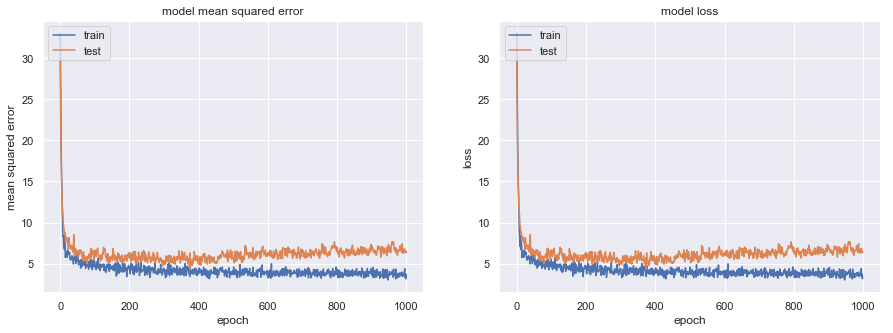

In [17]:
network_plot(history)

In [18]:
predictions = network_predict(mlp, np.expand_dims(ds.X_test, axis=2), ds.y_test)
comparison = np.concatenate((predictions, np.expand_dims(ds.y_test, axis=1)), axis=1)

In [19]:
np.set_printoptions(suppress=True)
comparison

array([[ -0.078     ,  -0.4       ],
       [  3.02999997,   3.7       ],
       [  5.64300013,   7.4       ],
       [ -0.078     ,  -0.2       ],
       [ -0.078     ,   0.4       ],
       [ -6.44099998,  -7.3       ],
       [ -6.76499987, -10.        ],
       [ -0.078     ,  -0.6       ],
       [-10.00199986, -10.        ],
       [ -0.078     ,   0.        ],
       [  0.25299999,   1.        ],
       [-10.08899975, -10.        ],
       [ -0.031     ,   0.2       ],
       [ -0.078     ,   0.2       ],
       [ -0.078     ,   0.        ],
       [ -0.078     ,   0.2       ],
       [ -0.078     ,  -0.2       ],
       [ -8.70499992,  -8.1       ],
       [ -0.015     ,  -0.        ],
       [  0.91000003,  -7.6       ],
       [ -0.078     ,  -0.        ],
       [ -1.60899997,  -0.6       ],
       [  8.52799988,  10.        ],
       [ -0.078     ,  -0.        ],
       [  4.05600023,  10.        ],
       [  3.97199988,   6.7       ],
       [ -0.078     ,   0.        ],
 

In [20]:
mlp.save("../mlp1_2.h5")

In [21]:
data = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])

data = np.expand_dims(data, axis=0)
data = np.expand_dims(data, axis=2)
network_predict(mlp, data, ds.y_test)

array([[3.609]], dtype=float32)